In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install dask-ml --quiet
!pip install dask --quiet
!pip install kmodes --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#df_init = pd.read_csv('/content/drive/MyDrive/df_base.csv', low_memory = False)
#df_init['fecha_suceso'] = pd.to_datetime(df_init['fecha_suceso'])
iter_csv = pd.read_csv('/content/drive/MyDrive/df_base.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[ pd.to_datetime(chunk['fecha_suceso']).dt.year  >= 2016] for chunk in iter_csv])
pd.set_option('display.max_columns', None)
df.head()

,num_denuncia,fecha_suceso,hora_suceso,direccion_suceso,fecha_denuncia,delito_completado_interrumpido,nivel_ofensa,distrito,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,geoespacial,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,diff_dias_hecho_denuncia,dia_suceso,estacion_suceso,mes_suceso
0,506547392,2018-03-29,Noche,32.0,2018-03-30,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,UNKNOWN,UNKNOWN,Desconocido,"(40.810877241, -73.941064151)",25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,1,jueves,primavera,abril
1,629632833,2018-02-06,Noche,52.0,2018-02-07,COMPLETED,MISDEMEANOR,BRONX,Policia,45-64,BLACK,Femenino,"(40.873671035, -73.908013649)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,1,martes,invierno,marzo
2,787203902,2018-11-21,Madrugada,75.0,2018-11-21,COMPLETED,MISDEMEANOR,BROOKLYN,Policia,25-44,WHITE,Femenino,"(40.651782232, -73.885456761)",UNKNOWN,UNKNOWN,Transgenero,extorsion,lugares publicos,0,miercoles,otono,diciembre
3,280364018,2018-06-09,Noche,10.0,2018-06-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,25-44,WHITE,Masculino,"(40.759310399, -73.994706072)",UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,1,sabado,verano,julio
4,985800320,2018-11-10,Noche,19.0,2018-11-10,COMPLETED,MISDEMEANOR,MANHATTAN,Policia,<18,BLACK,Femenino,"(40.764535539, -73.970728388)",UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,0,sabado,otono,diciembre


Acotaremos el ejercicio a los distritos donde más casos hubieron

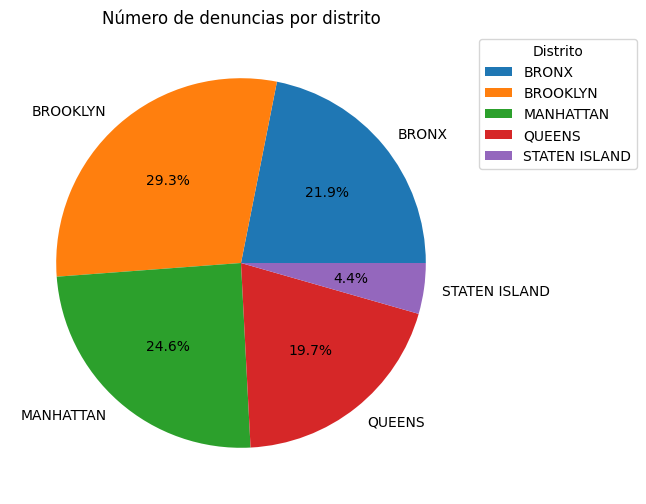

In [ ]:
distritos_counts = df.groupby(['distrito']).size()

# Crear un gráfico de torta
plt.figure(figsize=(6, 6))
distritos_counts.plot.pie(autopct='%1.1f%%')
plt.title('Número de denuncias por distrito')
plt.legend(title='Distrito', labels=distritos_counts.index, bbox_to_anchor=(1, 1))
plt.show()

## MANHATTAN

In [ ]:
df_manhattan = df[df.distrito == 'MANHATTAN'].copy()
df_manhattan.reset_index(inplace = True, drop = True)
df_manhattan['direccion_suceso'] = df_manhattan['direccion_suceso'].astype('object')

In [ ]:
df_manhattan.drop(columns= ['fecha_suceso', 'fecha_denuncia', 'num_denuncia', 'direccion_suceso', 'distrito', 'diff_dias_hecho_denuncia', 'nivel_ofensa'], inplace = True)

Separamos coordenadas

In [ ]:
df_manhattan['latitud'] = df_manhattan.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[0]))
df_manhattan['longitud'] = df_manhattan.geoespacial.apply(lambda x: float(x.replace('(', '').replace(')', '').split(',')[1]))
df_manhattan.drop(columns= ['geoespacial'], inplace = True)
df_manhattan.head()

,hora_suceso,delito_completado_interrumpido,jurisdiccion_encargada,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,latitud,longitud
0,Noche,COMPLETED,Policia,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,jueves,primavera,abril,40.810877,-73.941064
1,Noche,COMPLETED,Policia,25-44,WHITE,Masculino,UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,sabado,verano,julio,40.759310,-73.994706
2,Noche,COMPLETED,Policia,<18,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,sabado,otono,diciembre,40.764536,-73.970728
3,Mañana,COMPLETED,Transito,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,extorsion,necesidades diarias,lunes,primavera,abril,40.804384,-73.937422
4,Noche,COMPLETED,Policia,25-44,BLACK,Desconocido,25-44,BLACK,Masculino,delitos_graves,lugares publicos,miercoles,otono,octubre,40.803905,-73.952037


In [ ]:
from sklearn.preprocessing import MinMaxScaler
num_cols = df_manhattan.select_dtypes('number')
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(num_cols), columns = num_cols.columns.tolist())
df_manhattan_ready = pd.concat([df_manhattan.drop(columns = num_cols.columns.tolist()), scaled], axis = 1)
df_manhattan_ready_sample = df_manhattan_ready.sample(frac = 0.05, replace = True, random_state=1234)

## **1ra iteración:** de 2016 a 2019
- Sin reducción de de dimensionalidad y aplicación de KMeans y Spectral Clustering.

## **2da iteración:** De 2016 a 2019 y distrito con mayor número de casos
- Sin reducción de dimensionalidad y KModes.

### 1.1.1 Sin reducción de dimensionalidad y aplicación de KMeans.

Método del codo

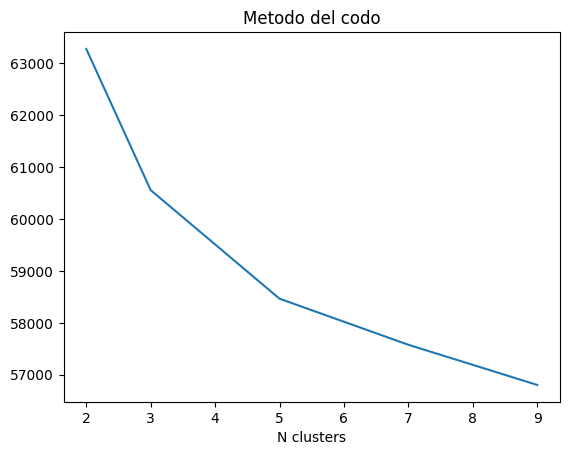

In [ ]:
from sklearn.metrics import silhouette_score  
from dask_ml.cluster import KMeans as KMeansDask
import dask.dataframe as da

# crear matriz Dask
sample = df_manhattan_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()


### Cohesión y Separabilidad con diferentes numero de clusters
- **Calinski-Harabasz:** cuanto mayor sea el valor del índice  se considera que el clustering es mejor.

- **Silhoutte Score:** Un valor cercano a 1 indica que las muestras están bien asignadas a sus clusters y están alejadas de los otros clusters vecinos. Un valor cercano a 0 indica que las muestras están en o cerca del límite de decisión entre dos clusters vecinos. Un valor cercano a -1 indica que las muestras pueden haber sido asignadas incorrectamente a sus clusters y que están más cerca de los otros clusters vecinos.

In [ ]:
from sklearn import metrics
sample = df_manhattan_ready_sample.copy()
dummies = pd.get_dummies(sample)
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 
n_clusters = [2,3,5,7,9]
km = []
metrics_df_general = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(X) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(X, labels)
  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(X, labels)
  metrics_df = pd.DataFrame({'Metodo': ['KMeans'],
                           'k':[k],
                           'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general = metrics_df_general.append(metrics_df, ignore_index=True)
metrics_df_general

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,2746.653442,0.103252
1,KMeans,3,2418.787910,0.106804
2,KMeans,5,1716.989560,0.085804
3,KMeans,7,1316.076073,0.075724
4,KMeans,9,1007.873576,0.084520


### Centroides con KMeans y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 

In [ ]:
centroides_manhattan = pd.DataFrame(centroids, columns = pd.get_dummies(df_manhattan_ready_sample).columns.tolist())
centroides_manhattan.reset_index(inplace = True, drop = False)
centroides_manhattan.rename(columns = {'index':'cluster'}, inplace =True)
centroides_manhattan

,cluster,latitud,longitud,hora_suceso_Madrugada,hora_suceso_Mañana,hora_suceso_Noche,hora_suceso_Tarde,delito_completado_interrumpido_ATTEMPTED,delito_completado_interrumpido_COMPLETED,jurisdiccion_encargada_Externas,jurisdiccion_encargada_Otras,jurisdiccion_encargada_Policia,jurisdiccion_encargada_Transito,jurisdiccion_encargada_Vivienda,grupo_edad_sospechoso_25-44,grupo_edad_sospechoso_45-64,grupo_edad_sospechoso_<18,grupo_edad_sospechoso_UNKNOWN,raza_sospechoso_AMERICAN INDIAN/ALASKAN NATIVE,raza_sospechoso_ASIAN / PACIFIC ISLANDER,raza_sospechoso_BLACK,raza_sospechoso_UNKNOWN,raza_sospechoso_WHITE,sexo_sospechoso_Desconocido,sexo_sospechoso_Femenino,sexo_sospechoso_Masculino,grupo_edad_victima_25-44,grupo_edad_victima_45-64,grupo_edad_victima_<18,grupo_edad_victima_UNKNOWN,raza_victima_AMERICAN INDIAN/ALASKAN NATIVE,raza_victima_ASIAN / PACIFIC ISLANDER,raza_victima_BLACK,raza_victima_UNKNOWN,raza_victima_WHITE,sexo_victima_Femenino,sexo_victima_Masculino,sexo_victima_Transgenero,tipo_crimen_armas_drogas,tipo_crimen_crimenes_sexuales,tipo_crimen_delitos_graves,tipo_crimen_extorsion,tipo_crimen_incidentes_menores,tipo_crimen_otros_crimenes,lugar_Otros,lugar_diversion y turismo,lugar_lugares publicos,lugar_lugares solitarios,lugar_necesidades diarias,dia_suceso_domingo,dia_suceso_jueves,dia_suceso_lunes,dia_suceso_martes,dia_suceso_miercoles,dia_suceso_sabado,dia_suceso_viernes,estacion_suceso_invierno,estacion_suceso_otono,estacion_suceso_primavera,estacion_suceso_verano,mes_suceso_abril,mes_suceso_agosto,mes_suceso_diciembre,mes_suceso_febrero,mes_suceso_julio,mes_suceso_junio,mes_suceso_marzo,mes_suceso_mayo,mes_suceso_noviembre,mes_suceso_octubre,mes_suceso_septiembre
0,0,0.590559,0.244501,0.146315,0.166869,0.270615,0.416200,0.022744,0.977256,0.016419,0.015690,0.823887,0.070421,0.073583,0.279372,0.129652,0.021892,0.569083,0.001338,0.020798,0.375578,0.364753,0.237533,0.350036,0.115300,0.534663,0.000000,0.000243,0.000000,0.999757,0.000000,0.000730,0.000851,0.997203,0.001216,0.006811,0.010338,0.982851,0.152274,0.017392,0.016298,0.585624,0.207249,0.021163,0.032474,0.510095,0.328266,0.030285,0.098881,0.111408,0.159329,0.128193,0.143274,0.158842,0.137801,0.161153,0.233398,0.252250,0.249939,0.264413,0.081002,0.085989,0.154099,0.089151,0.088908,0.090124,0.068596,0.078813,0.093894,0.079908,0.089516
1,1,0.602880,0.249786,0.144951,0.213249,0.283600,0.358200,0.020665,0.979335,0.002931,0.008208,0.905760,0.032537,0.050564,0.003078,0.001905,0.000879,0.994137,0.000293,0.001905,0.010113,0.977722,0.009966,0.948263,0.020959,0.030778,0.460501,0.250916,0.027554,0.261029,0.007914,0.106551,0.244174,0.080903,0.560457,0.475158,0.523963,0.000879,0.001026,0.087938,0.067566,0.705994,0.132933,0.004543,0.034735,0.205775,0.658655,0.018027,0.082808,0.125458,0.141580,0.144365,0.136450,0.137183,0.151253,0.163711,0.227466,0.249744,0.249744,0.273047,0.079291,0.087938,0.169134,0.073135,0.091162,0.091748,0.068445,0.078704,0.088671,0.077825,0.093947
2,2,0.629210,0.267624,0.179325,0.196576,0.294413,0.329686,0.018538,0.981462,0.004506,0.008368,0.791195,0.046601,0.149331,0.418641,0.143023,0.046859,0.391478,0.003991,0.034758,0.545314,0.068357,0.347580,0.016993,0.229145,0.753862,0.479660,0.232621,0.063723,0.223996,0.007853,0.087539,0.388131,0.055742,0.460736,0.564753,0.434861,0.000386,0.004892,0.325953,0.308316,0.177652,0.156668,0.026519,0.033342,0.131437,0.720778,0.022657,0.091787,0.149846,0.144567,0.132595,0.139676,0.144053,0.145469,0.143795,0.227858,0.257595,0.249356,0.265191,0.079686,0.092302,0.160402,0.076854,0.089083,0.087410,0.070417,0.082261,0.090886,0.086895,0.083805


In [ ]:
manhattan_kmeans_sin_reduccion = df_manhattan_ready_sample.copy()
manhattan_kmeans_sin_reduccion['clusters'] = kmeans.labels_

### 1.2 Con reducción de dimensionalidad y aplicación de KMeans.

In [ ]:
from dask_ml.decomposition import PCA

dummies = pd.get_dummies(df_manhattan_ready_sample, dtype ='int')
# crear matriz Dask
X = da.from_pandas(dummies, npartitions=10).to_dask_array(lengths=True) 

# crear objeto PCA
pca = PCA(n_components=X.shape[1])

# ajustar el modelo
pca.fit(X)

PCA(n_components=70)

In [ ]:
pca.explained_variance_ratio_[:40].sum(axis = 0)

0.9690083975256968

In [ ]:
pca = PCA(n_components=40)
X_PCA =pca.fit_transform(X)
#X_PCA = X_PCA.compute() 

In [ ]:
X_PCA_ok = pd.DataFrame(X_PCA, columns = ['component'+str(column) for column in range(X_PCA.shape[1])])
X_PCA_ok.head()

,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,1.153740,-0.847465,-1.089861,0.520391,-0.012289,0.339865,-1.105401,-0.336988,0.349841,-0.208328,0.048403,0.261071,-0.470578,-0.335380,-0.281003,-0.544732,0.025674,-0.828413,0.264677,-0.112784,-0.138541,0.028775,-0.710225,0.593609,0.011520,0.002936,0.214989,-0.204696,-0.155976,0.063850,0.035924,-0.048810,-0.005018,0.097724,0.040901,-0.102044,0.074206,-0.106215,0.060825,0.096843
1,-1.443205,0.553241,0.477158,0.496635,0.317943,0.328505,0.110623,-1.600419,-0.187982,0.050163,-0.486159,0.403070,-0.013325,-0.102501,0.153191,0.194632,0.548560,0.302495,-0.466946,0.104133,-0.605570,0.060581,-0.578695,-0.020837,-0.177719,-0.363000,-0.229876,0.485012,0.087418,-0.022922,0.016837,0.026670,-0.048843,0.076625,0.076819,-0.193174,-0.027457,0.156556,-0.052371,-0.084472
2,-1.123012,0.282495,0.361731,0.585573,0.382664,0.488880,0.612489,-0.664292,-0.971016,0.104979,-0.625409,0.119425,0.603052,0.580782,0.059208,-0.220981,-0.648509,0.354103,0.889649,0.276642,-0.102104,0.185999,-0.764325,-0.088883,0.114816,1.038852,-0.539571,-0.210408,-0.212240,0.105929,0.008697,-0.029184,0.062111,-0.002452,-0.040255,-0.079655,-0.123970,0.209695,-0.231331,-0.140219
3,-1.747309,-0.008459,-0.885239,0.261683,0.636388,0.274048,-0.081974,0.713685,0.001731,-0.165857,0.849815,0.298185,0.105643,0.233020,-0.024869,0.502540,-0.276781,0.114084,-0.209750,0.853993,0.209975,-0.157807,-0.741247,0.224733,0.093708,0.292178,-0.156063,-0.288070,-0.613581,0.059120,-0.043040,0.018979,-0.017880,0.063446,-0.041441,-0.108042,0.017381,0.018926,-0.056285,0.033507
4,0.448796,0.567438,0.969980,0.609123,-0.978195,-0.191265,-0.138828,0.550958,0.317958,-0.360164,0.810648,-0.249362,0.327201,0.076408,0.906341,-0.023183,-0.158439,-0.969650,0.111615,-0.115494,-0.299437,-0.236742,-0.027870,-0.515742,-0.160443,-0.610184,0.597788,-0.075486,-0.598580,-0.046794,-0.044785,-0.606953,-0.188176,-0.292096,0.277875,0.223197,-0.659217,-0.121237,-0.248379,-0.006301


Según el método del codo, cuántos cluster serían una elección óptima?

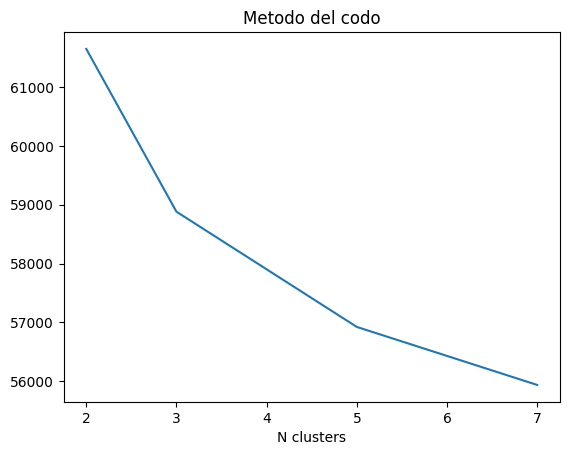

In [ ]:
n_clusters = [2, 3, 5, 7]

km = []

for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k, random_state = 1234)
  kmeans.fit(X_PCA_ok)
  km.append(kmeans.inertia_)

plt.title('Metodo del codo')
plt.xlabel('N clusters')
plt.plot(n_clusters, km)
plt.show()

### Calinski-Harabasz Index y Silhouette Coefficient para n clusters en KMeans con PCA

In [ ]:
metrics_df_general_pca = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])
n_clusters = [2,3,5,7,9]
km = []
sample = X_PCA_ok.sample(frac=0.3)
for k in n_clusters:
  kmeans = KMeansDask(n_clusters=k)
  kmeans.fit(sample) 
  labels = kmeans.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KMeans_PCA'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_pca = metrics_df_general_pca.append(metrics_df, ignore_index=True)

metrics_df_general_pca

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans_PCA,2,801.849735,0.100205
1,KMeans_PCA,3,756.083284,0.110207
2,KMeans_PCA,5,531.685108,0.088195
3,KMeans_PCA,7,417.828148,0.083962
4,KMeans_PCA,9,330.911165,0.058828


### Centroides con KMeans y PCA y clusters igual a 3

In [ ]:
kmeans = KMeansDask(n_clusters=3, random_state = 1234)
kmeans.fit(X_PCA_ok)
centroids = kmeans.cluster_centers_ 
labels = kmeans.labels_ 

In [ ]:
centroides_mahattan_pca = pd.DataFrame(centroids, columns = X_PCA_ok.columns.tolist())
centroides_mahattan_pca.reset_index(inplace = True, drop = False)
centroides_mahattan_pca.rename(columns = {'index':'cluster'}, inplace =True)
centroides_mahattan_pca

,cluster,component0,component1,component2,component3,component4,component5,component6,component7,component8,component9,component10,component11,component12,component13,component14,component15,component16,component17,component18,component19,component20,component21,component22,component23,component24,component25,component26,component27,component28,component29,component30,component31,component32,component33,component34,component35,component36,component37,component38,component39
0,0,0.240299,1.085694,-0.081506,-0.005004,-0.024523,0.010103,0.007411,0.013856,0.019943,-0.052115,-0.004940,-0.028157,0.080674,-0.043528,-0.003144,-0.017588,-0.041944,-0.009733,0.006397,-0.002264,0.019801,-0.004571,-0.004072,-0.033630,-0.011752,0.001706,0.027275,0.026116,0.002131,-0.007548,-0.010245,-0.004254,-0.012465,-0.012619,-0.008834,-0.001053,-0.016024,0.017692,-0.005063,-0.006452
1,1,1.107254,-0.603014,-0.078074,-0.008495,0.000727,0.005368,-0.001569,0.013718,0.013949,0.059994,0.026472,0.007305,-0.022794,0.040218,-0.005732,-0.014523,0.086852,0.018189,-0.006909,-0.005888,0.009863,0.000568,0.006435,-0.010623,-0.011193,0.003615,0.008200,0.008982,-0.038654,0.001514,-0.007081,0.003341,-0.017884,-0.002886,-0.001344,0.003982,0.022297,-0.021863,0.004797,0.010357
2,2,-1.148072,-0.512173,0.141314,0.011763,0.022321,-0.013923,-0.005621,-0.024395,-0.030278,-0.001309,-0.017458,0.020232,-0.056416,0.007156,0.007720,0.028556,-0.033217,-0.006069,-0.000219,0.007028,-0.026738,0.003799,-0.001559,0.040301,0.020322,-0.004610,-0.032339,-0.031908,0.030243,0.005794,0.015484,0.001190,0.026569,0.014204,0.009380,-0.002336,-0.003613,0.001692,0.000733,-0.002605


### **2 Sin reducción de dimensionalidad y aplicación de KModes.**

Se excluyen algunas variables para el análisis

In [ ]:
df_manhattan_ready.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)
df_manhattan_ready_sample.drop(columns = ['jurisdiccion_encargada', 'latitud', 'longitud'], inplace = True)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


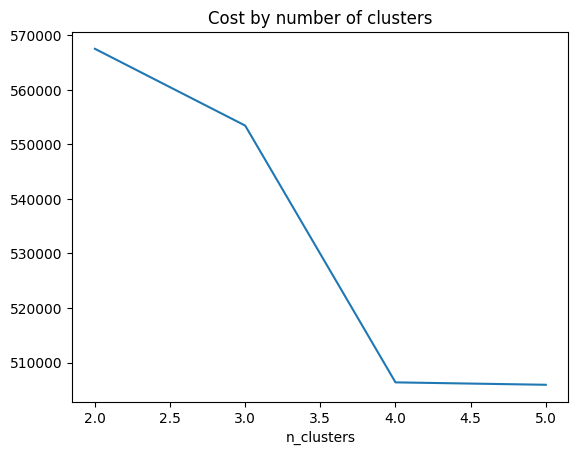

In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)

cost = []
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(categoricas_manhattan_encoded.sample(frac =0.2))
  cost.append(kmodes.cost_)

plt.title('Cost by number of clusters')
plt.xlabel('n_clusters')
plt.plot(n_clusters, cost)
plt.show()

In [ ]:
encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)
metrics_df_general_kmodes = pd.DataFrame([], columns=['Metodo','k','Calinski-Harabasz Index','Silhouette Coefficient'])

sample = categoricas_manhattan_encoded.sample(frac =0.5)
n_clusters = [2,3,4,5]
for k in n_clusters:
  kmodes = KModes(n_clusters=k, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
  kmodes.fit(sample)
  labels = kmodes.labels_ 
  # Calinski-Harabasz Index
  ch_score = metrics.calinski_harabasz_score(sample, labels)

  # Silhouette Coefficient
  silhouette_avg = metrics.silhouette_score(sample, labels)

  metrics_df = pd.DataFrame({'Metodo': ['KModes'],
                            'k':[k],
                            'Calinski-Harabasz Index': [ch_score],
                            'Silhouette Coefficient': [silhouette_avg]})
  metrics_df_general_kmodes = metrics_df_general_kmodes.append(metrics_df, ignore_index=True)
metrics_df_general_kmodes

Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.
Initialization method and algorithm are deterministic. Setting n_init to 1.


,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KModes,2,10457.160750,0.047752
1,KModes,3,8938.454738,0.042889
2,KModes,4,7065.145502,0.028536
3,KModes,5,6089.520113,0.012111


In [ ]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder(dtype = 'int64').set_output(transform = 'pandas')
categoricas_manhattan = df_manhattan_ready.copy()
categoricas_manhattan_encoded = encoder.fit_transform(df_manhattan_ready)

In [ ]:
kmodes = KModes(n_clusters=4, init = 'Cao', verbose = 1, n_jobs=-1, random_state=1234, n_init=5)
categoricas_manhattan_encoded['labels'] = kmodes.fit_predict(categoricas_manhattan_encoded)
categoricas_manhattan['labels']  = categoricas_manhattan_encoded['labels'] 
categoricas_manhattan.head()

Initialization method and algorithm are deterministic. Setting n_init to 1.


,hora_suceso,delito_completado_interrumpido,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,Noche,COMPLETED,UNKNOWN,UNKNOWN,Desconocido,25-44,WHITE,Femenino,incidentes_menores,lugares solitarios,jueves,primavera,abril,1
1,Noche,COMPLETED,25-44,WHITE,Masculino,UNKNOWN,WHITE,Femenino,incidentes_menores,lugares publicos,sabado,verano,julio,1
2,Noche,COMPLETED,<18,BLACK,Femenino,UNKNOWN,UNKNOWN,Transgenero,extorsion,diversion y turismo,sabado,otono,diciembre,0
3,Mañana,COMPLETED,UNKNOWN,UNKNOWN,Desconocido,UNKNOWN,UNKNOWN,Transgenero,extorsion,necesidades diarias,lunes,primavera,abril,0
4,Noche,COMPLETED,25-44,BLACK,Desconocido,25-44,BLACK,Masculino,delitos_graves,lugares publicos,miercoles,otono,octubre,2


In [ ]:
pd.DataFrame(kmodes.cluster_centroids_, columns = categoricas_manhattan_encoded.columns)

,hora_suceso,delito_completado_interrumpido,grupo_edad_sospechoso,raza_sospechoso,sexo_sospechoso,grupo_edad_victima,raza_victima,sexo_victima,tipo_crimen,lugar,dia_suceso,estacion_suceso,mes_suceso,labels
0,3,1,3,3,2,3,3,2,3,1,6,1,2,0
1,2,1,0,2,2,0,4,0,2,2,0,3,4,1
2,3,1,3,3,0,0,4,1,3,2,5,1,2,3
3,1,1,3,3,0,1,2,0,3,2,4,2,0,3
4,2,1,3,4,2,3,4,1,1,2,2,2,5,1


In [ ]:
encoder.inverse_transform(pd.DataFrame(kmodes.cluster_centroids_, columns = categoricas_manhattan_encoded.columns))

ValueError: ignored

In [ ]:
metrics_df_general_kmodes

,Metodo,k,Calinski-Harabasz Index,Silhouette Coefficient
0,KMeans,2,3651.739746,0.045192
1,KMeans,3,6257.370713,0.074271
2,KMeans,4,4273.782699,0.040643
3,KMeans,5,3493.062822,0.022943


In [ ]:
from sklearn import metrics

sample = categoricas_manhattan_encoded.sample(frac = 0.4)
labels = sample['labels'].values

#X = pd.get_dummies(sample.drop(columns = ['labels']), dtype = 'int')
X = sample.copy()

# Calinski-Harabasz Index
ch_score = metrics.calinski_harabasz_score(X, labels)

# Silhouette Coefficient
silhouette_avg = metrics.silhouette_score(X, labels)

metrics_df = pd.DataFrame({'Calinski-Harabasz Index': [ch_score],
                           'Silhouette Coefficient': [silhouette_avg]})
metrics_df

,Calinski-Harabasz Index,Silhouette Coefficient
0,9563.091707,0.066384


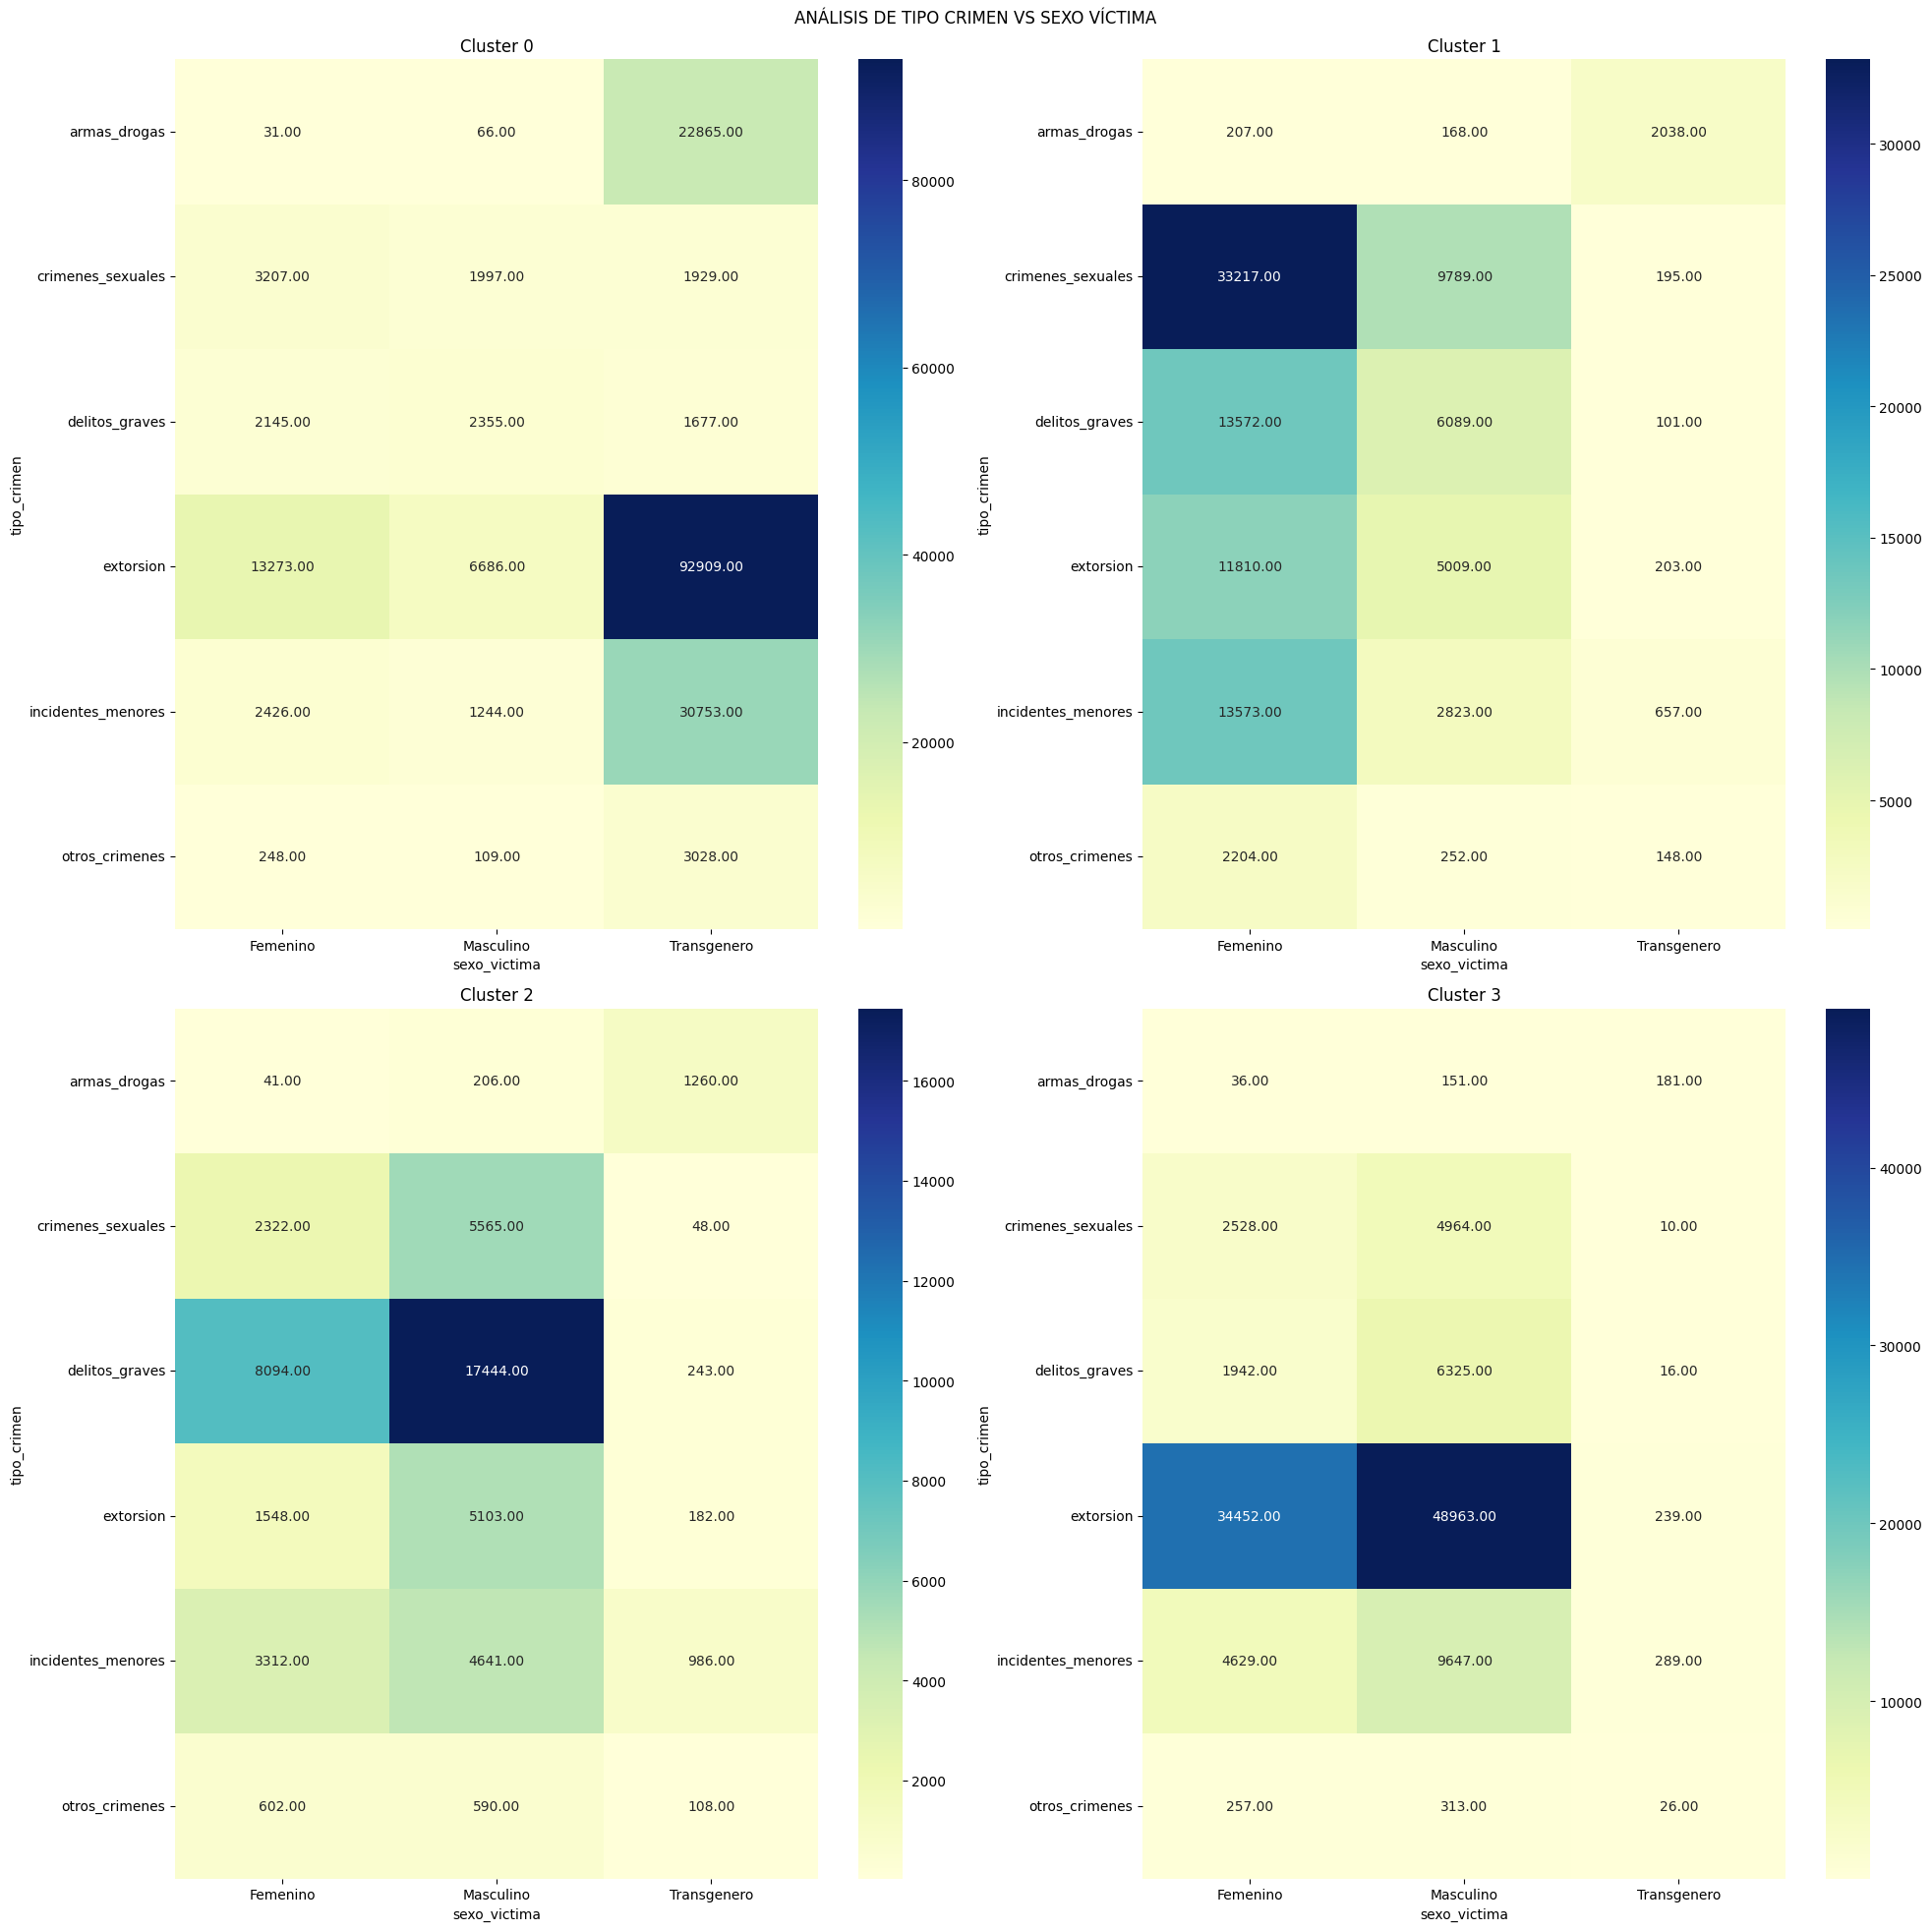

In [ ]:
manhattan_cluster0 = categoricas_manhattan[categoricas_manhattan['labels']==0]
manhattan_cluster1 = categoricas_manhattan[categoricas_manhattan['labels']==1]
manhattan_cluster2 = categoricas_manhattan[categoricas_manhattan['labels']==2]
manhattan_cluster3 = categoricas_manhattan[categoricas_manhattan['labels']==3]

fig, ax = plt.subplots(2,2, figsize = (20,20))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS SEXO VÍCTIMA \n')
ct0 = pd.crosstab(manhattan_cluster0['tipo_crimen'], manhattan_cluster0['sexo_victima'])
ct1 = pd.crosstab(manhattan_cluster1['tipo_crimen'], manhattan_cluster1['sexo_victima'])
ct2 = pd.crosstab(manhattan_cluster2['tipo_crimen'], manhattan_cluster2['sexo_victima'])
ct3 = pd.crosstab(manhattan_cluster3['tipo_crimen'], manhattan_cluster3['sexo_victima'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0,0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0,1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1,0])
sns.heatmap(ct3, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1,1])

ax[0,0].set_title('Cluster 0')
ax[0,1].set_title('Cluster 1')
ax[1,0].set_title('Cluster 2')
ax[1,1].set_title('Cluster 3')

plt.tight_layout()
plt.show()

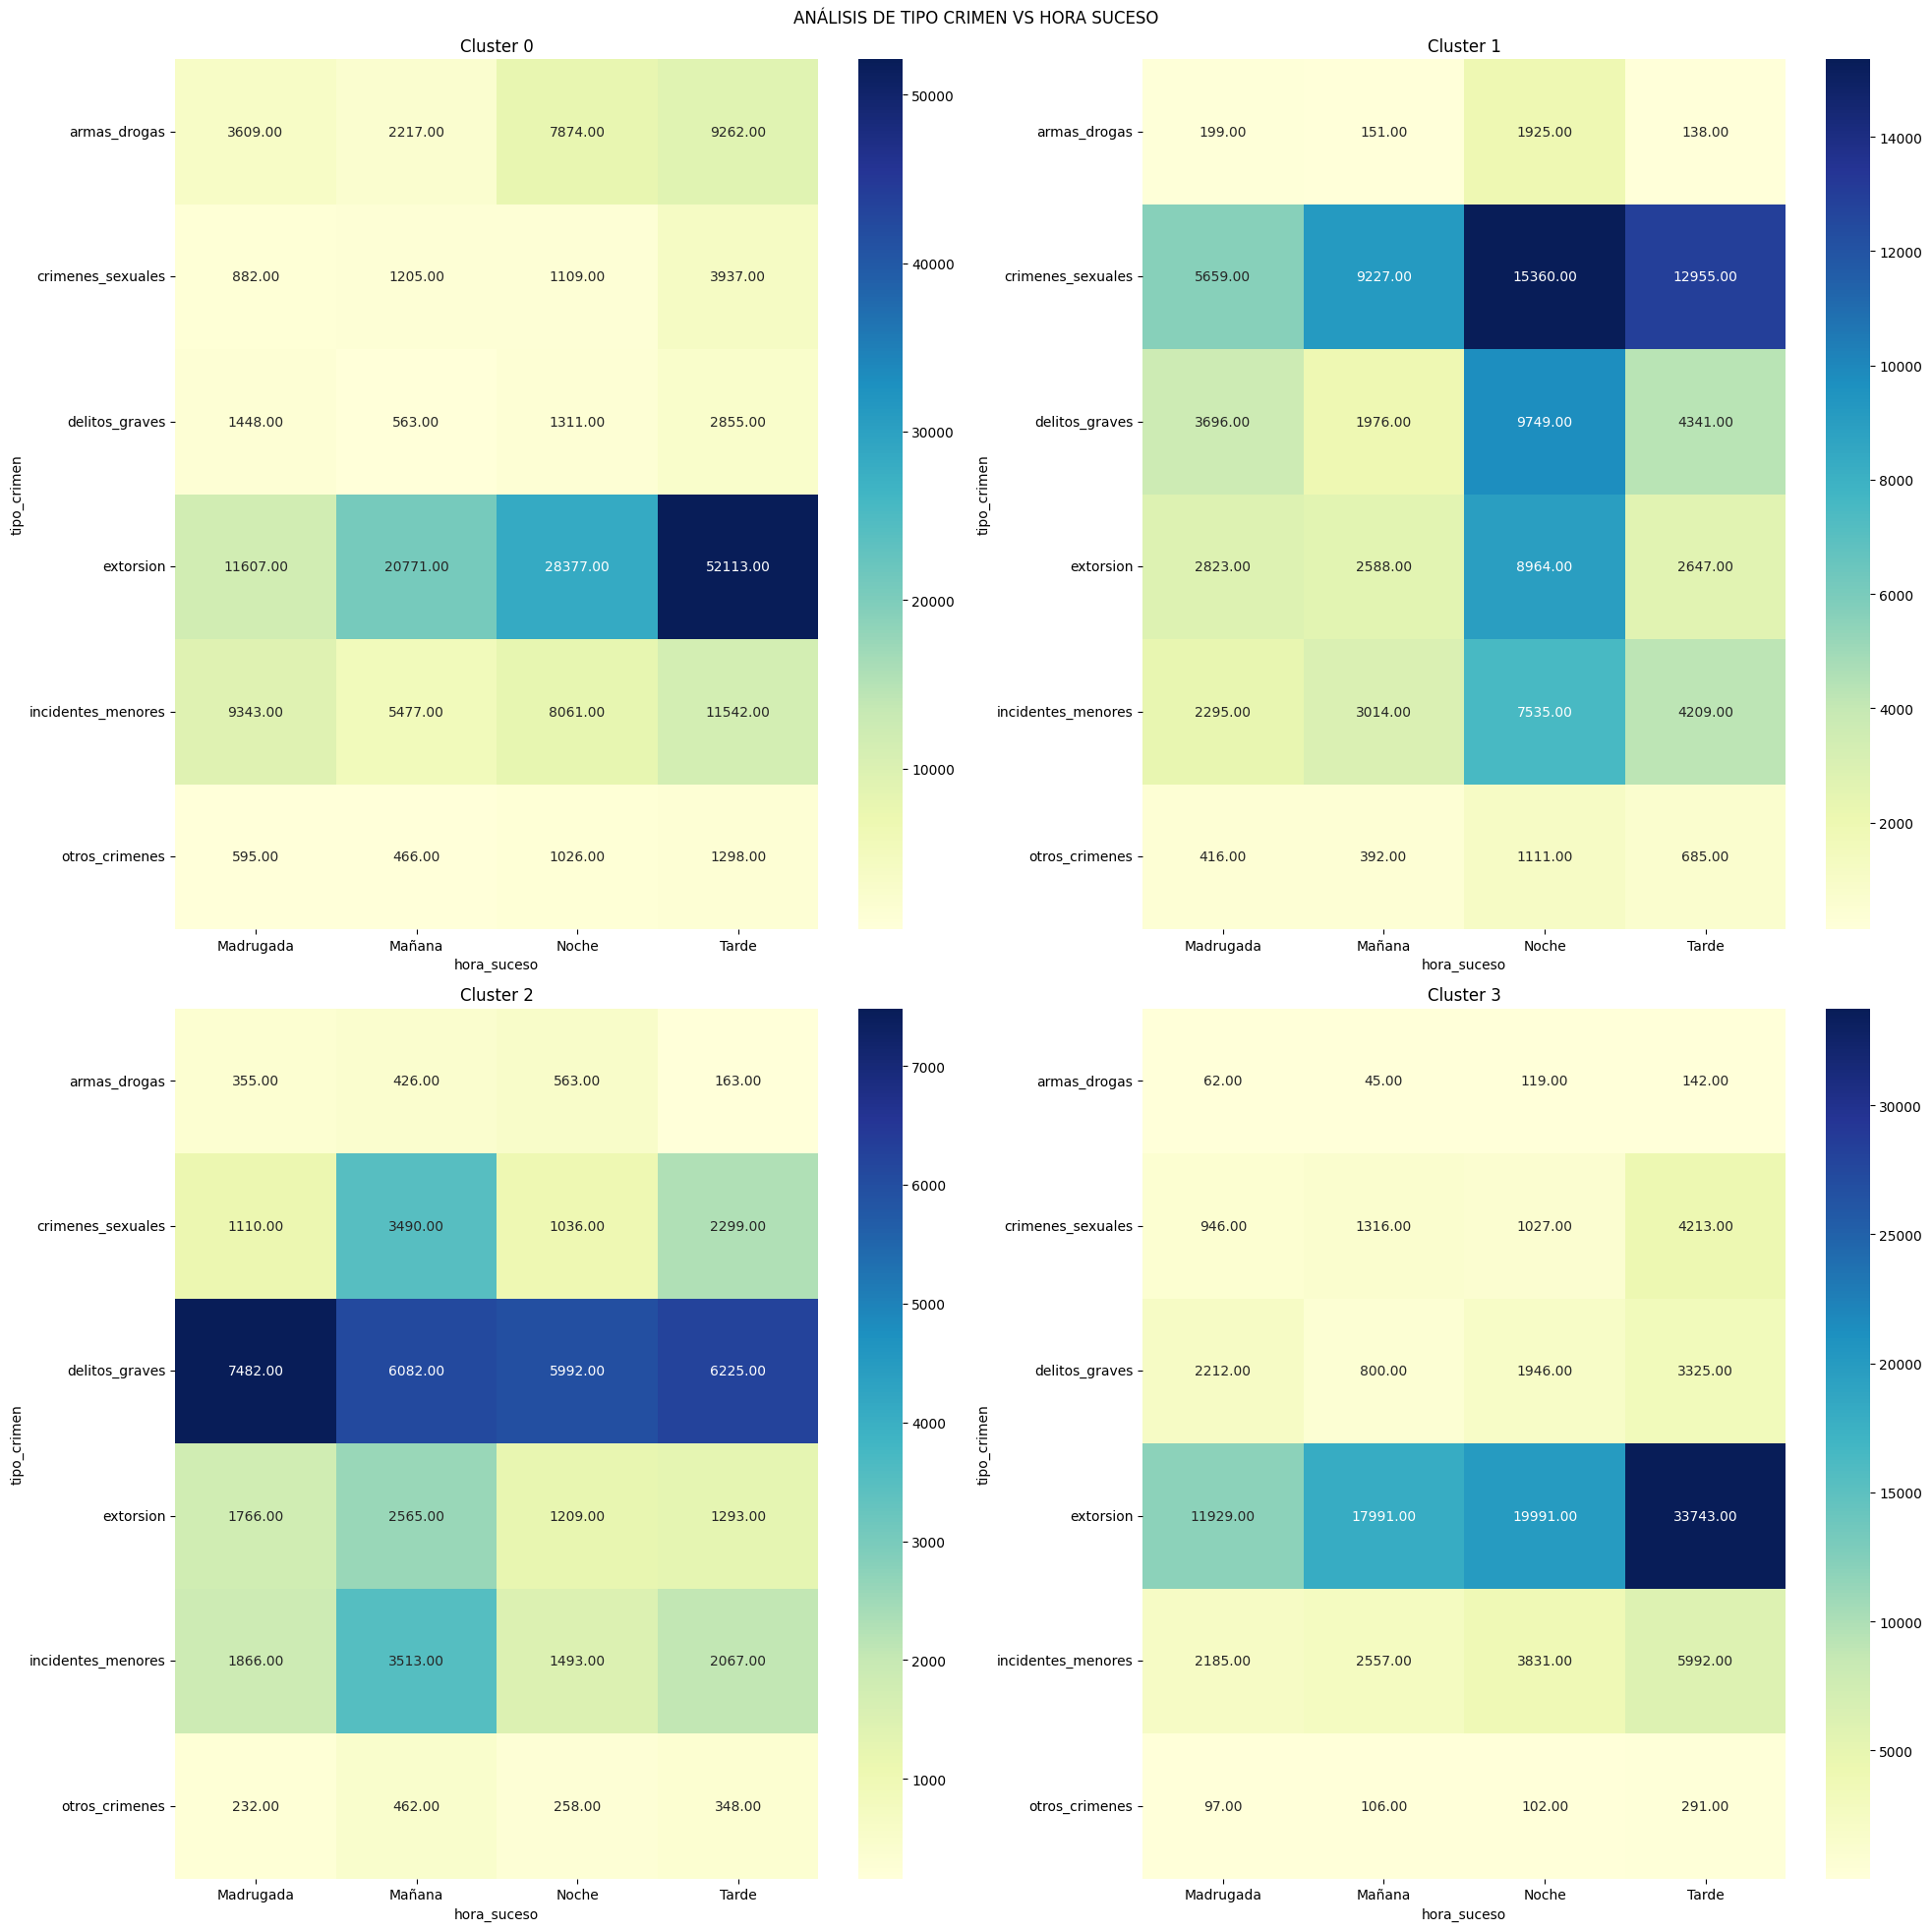

In [ ]:
fig, ax = plt.subplots(2,2, figsize = (20,20))
fig.suptitle('ANÁLISIS DE TIPO CRIMEN VS HORA SUCESO \n')
ct0 = pd.crosstab(manhattan_cluster0['tipo_crimen'], manhattan_cluster0['hora_suceso'])
ct1 = pd.crosstab(manhattan_cluster1['tipo_crimen'], manhattan_cluster1['hora_suceso'])
ct2 = pd.crosstab(manhattan_cluster2['tipo_crimen'], manhattan_cluster2['hora_suceso'])
ct3 = pd.crosstab(manhattan_cluster3['tipo_crimen'], manhattan_cluster3['hora_suceso'])

# Crear un mapa de calor de la tabla de frecuencia cruzada
sns.heatmap(ct0, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0,0])
sns.heatmap(ct1, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[0,1])
sns.heatmap(ct2, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1,0])
sns.heatmap(ct3, annot=True, cmap='YlGnBu', fmt = '.2f', ax = ax[1,1])

ax[0,0].set_title('Cluster 0')
ax[0,1].set_title('Cluster 1')
ax[1,0].set_title('Cluster 2')
ax[1,1].set_title('Cluster 3')

plt.tight_layout()
plt.show()